<a href="https://colab.research.google.com/github/SAMAWELJABALLI/TweetsSentimentAnalysis/blob/main/BLSTM_Model_on_corpus2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils import resample
    
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.models import load_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# Load data and set labels from corpus 1 
header_list = [ "label", "text_clean"]
data = pd.read_csv('/content/TUNIZI-Dataset.txt',sep=';')
# Display 20 random samples
print(f'Shape of data is {data.shape}')
data.sample(20)

FileNotFoundError: ignored

# Duplicate Sentence

Most webscrapped data contains duplicated sentence.This function could retrieve unique ones.

In [4]:
def pick_unique_sentence(text):
    line=re.findall(r'(?sm)(^[^\r\n]+$)(?!.*^\1$)', text)
    return line


In [5]:
sentence="ya wa7ch dima a3ml talla\n I thank doctors\nDoctors are working very hard in this pandemic situation\nI thank doctors bravo lik y wa7ch \nya wa7ch dima a3ml talla\n  "
pick_unique_sentence(sentence)

[' I thank doctors',
 'Doctors are working very hard in this pandemic situation',
 'I thank doctors bravo lik y wa7ch ',
 'ya wa7ch dima a3ml talla',
 '  ']

In [4]:
data["text_clean"].fillna("No content", inplace = True)
data['pick_unique']=data['text_clean'].apply(lambda x : pick_unique_sentence(x))
data.sample(20)

,label,text_clean,pick_unique
562,1,thabel hhhh,[thabel hhhh]
442,1,hayla,[hayla]
580,1,yeki fama halka hdech,[yeki fama halka hdech]
1007,1,loooooooooooool are u f kidding me,[loooooooooooool are u f kidding me]
1293,1,famachkoun hhh deja tfol fi 8,[famachkoun hhh deja tfol fi 8]
1381,1,miss mima ranim nchlh ya rabi,[miss mima ranim nchlh ya rabi]
1502,-1,chnbki 11 yeares ago,[chnbki 11 yeares ago]
2804,-1,nik omek y miguelou lemesse5 w te7enet lfessed...,[nik omek y miguelou lemesse5 w te7enet lfesse...
2932,-1,w howa wach dakhlo w yzid yafda7 fiha,[w howa wach dakhlo w yzid yafda7 fiha]
2602,-1,tehchy fih 3asba ta7ger fi rjel ya3tek 3asba,[tehchy fih 3asba ta7ger fi rjel ya3tek 3asba]


# remove repeated lettre

In [5]:
def rep(text):
    grp = text.group(0)
    if len(grp) > 1:
        return grp[0:1] # can change the value here on repetition
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert


In [6]:
sentence="مااااسط مااااسط bravoooooooooooooo degaage"
unique_char(rep,sentence)

'ماسط ماسط bravo degage'

In [7]:
data['pick_unique']=data['pick_unique'].apply(str)
data['unique_char']=data['pick_unique'].apply(lambda x : unique_char(rep,x))
data.head(20)

,label,text_clean,pick_unique,unique_char
0,1,ana fil ghorba w sout el athan ahla haja 3ijbi...,['ana fil ghorba w sout el athan ahla haja 3ij...,['ana fil ghorba w sout el athan ahla haja 3ij...
1,1,man eheb rasoule mohamed,['man eheb rasoule mohamed'],['man eheb rasoule mohamed']
2,1,rabi yerhmou sofiane cha3ri,['rabi yerhmou sofiane cha3ri'],['rabi yerhmou sofiane cha3ri']
3,1,rabi yarahmak ya sbou3i wou yarham kol om mita,['rabi yarahmak ya sbou3i wou yarham kol om mi...,['rabi yarahmak ya sbou3i wou yarham kol om mi...
4,1,merci beaucoup salime,['merci beaucoup salime'],['merci beaucoup salime']
5,1,tomson et banane,['tomson et banane'],['tomson et banane']
6,1,2020 winkom hhh,['2020 winkom hhh'],['2020 winkom h']
7,1,chkoun 9a3ed ytfrj fi e5r nhar ta3 2019,['chkoun 9a3ed ytfrj fi e5r nhar ta3 2019'],['chkoun 9a3ed ytfrj fi e5r nhar ta3 2019']
8,1,ahhhhhhhhhh alah yarhmou,['ahhhhhhhhhh alah yarhmou'],['ah alah yarhmou']
9,1,31 decembre 2019 n3amkom mabrouk nés lkoll,['31 decembre 2019 n3amkom mabrouk nés lkoll'],['31 decembre 2019 n3amkom mabrouk nés lkol']


# 1-grame features extracted from processed_text

In [8]:
def ngrams_top(corpus,ngram_range,n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus.values.astype('U'))
    bag_of_words = vec.transform((corpus).values.astype('U'))
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

In [9]:
une_gram =ngrams_top(data['unique_char'],(1,1),n=200)
une_gram.values.tolist()


[['ya', 389],
 ['fi', 310],
 ['bravo', 257],
 ['el', 195],
 ['rabi', 167],
 ['ken', 110],
 ['ma', 101],
 ['kol', 98],
 ['eli', 97],
 ['mala', 95],
 ['la', 93],
 ['3la', 88],
 ['il', 75],
 ['walah', 72],
 ['barcha', 71],
 ['de', 68],
 ['men', 68],
 ['fih', 68],
 ['ki', 68],
 ['tounes', 67],
 ['li', 62],
 ['ama', 62],
 ['ou', 61],
 ['les', 61],
 ['bech', 60],
 ['ena', 58],
 ['bara', 58],
 ['le', 56],
 ['alah', 55],
 ['wlh', 55],
 ['et', 54],
 ['mouch', 54],
 ['min', 52],
 ['fil', 51],
 ['ye', 49],
 ['3ala', 48],
 ['enti', 47],
 ['ti', 47],
 ['chkoun', 46],
 ['ala', 46],
 ['yeser', 44],
 ['mis', 44],
 ['3asba', 44],
 ['si', 42],
 ['basem', 42],
 ['omek', 42],
 ['fel', 41],
 ['clip', 41],
 ['est', 40],
 ['karim', 40],
 ['en', 39],
 ['3al', 39],
 ['haka', 39],
 ['mara', 38],
 ['inti', 37],
 ['top', 37],
 ['nes', 37],
 ['je', 37],
 ['ana', 36],
 ['kif', 36],
 ['kima', 36],
 ['wala', 36],
 ['tawa', 35],
 ['rajel', 35],
 ['nik', 35],
 ['haja', 34],
 ['tayara', 34],
 ['we', 34],
 ['ili', 33],
 

In [10]:
noise1gram=set(['wiw','inti','inty','na','je','wé','ena','cete','رجلرجل','eni','ana','انت','ben','عن','al','mes','و','w','mel','wel','jour','come','هو','بعد','inti','الى','se','lkol','fama','bel','فيه','ele','فى','kima','haka','kan','nes','بينا','votre','par','ya','mr','une', 'cest','vous','ont','sont','nous','kif','علي','faire','dans','fel','ala','ana','taw','ye','mon','tout','bravobravo','col','مع','li','ça','de','ya','في','et','fi','el','je','من','les','pour','est','على','il','des','si','vous','en','que','cest','الي','kol','eli','un','يا','une','ما','bech','ou','ken','كل','men','كان','jai','باش','ama','mala','cette','هذا','انا','ان','avec','du','dima','ce','min','ili','ki','enti','fih','tawa','qui','au','ena','fil','suis','wa'])
len(noise1gram)

112

# 2-grame features extracted from processed_text


In [11]:
deux_gram =ngrams_top(data['unique_char'],(2,2),n=100)
deux_gram.values.tolist()


[['fi tounes', 17],
 ['kol chay', 13],
 ['bravo bravo', 13],
 ['ya rabi', 13],
 ['baya zardi', 11],
 ['ya weld', 11],
 ['nik omek', 10],
 ['bara nik', 10],
 ['nes lkol', 9],
 ['de la', 9],
 ['ya m3alem', 9],
 ['fi tunis', 8],
 ['el kol', 8],
 ['nchalah rabi', 8],
 ['nour chiba', 8],
 ['3ich tounsi', 8],
 ['chapeau bas', 7],
 ['awel mara', 7],
 ['ya hasra', 7],
 ['ya 7asra', 7],
 ['franã ais', 7],
 ['3asba lik', 7],
 ['omk ya', 7],
 ['et merci', 6],
 ['bon courage', 6],
 ['jozef dh', 6],
 ['hend sabri', 6],
 ['ya zebi', 6],
 ['jalad yt', 6],
 ['ken jit', 6],
 ['ken jet', 6],
 ['zok omkom', 6],
 ['ya ta7an', 6],
 ['ya3tek 3asba', 6],
 ['mel mout', 6],
 ['dã jã', 6],
 ['jã xa0', 6],
 ['nik omok', 6],
 ['ya jabri', 6],
 ['ya sbou3i', 5],
 ['choufli hal', 5],
 ['ele est', 5],
 ['mariem dabegh', 5],
 ['que tu', 5],
 ['tayara barcha', 5],
 ['en boucle', 5],
 ['mouch normal', 5],
 ['ya3mel abonè', 5],
 ['abonè lel', 5],
 ['lel chaine', 5],
 ['chaine mta3y', 5],
 ['mta3y tarja3lou', 5],
 ['tarj

# 3-grame features extracted from processed_text


In [12]:
trois_gram =ngrams_top(data['unique_char'],(3,3),n=100)
trois_gram.values.tolist()


[['bravo bravo bravo', 6],
 ['dã jã xa0', 6],
 ['ya3mel abonè lel', 5],
 ['abonè lel chaine', 5],
 ['lel chaine mta3y', 5],
 ['chaine mta3y tarja3lou', 5],
 ['mta3y tarja3lou et', 5],
 ['tarja3lou et merci', 5],
 ['fi baya zardi', 4],
 ['silmia silmia khawa', 4],
 ['silmia khawa khawa', 4],
 ['bara nik omok', 4],
 ['ishak fot stars', 4],
 ['eli ya3mel abonè', 3],
 ['netmana lik lmout', 3],
 ['lik lmout ki', 3],
 ['si ali chouchen', 3],
 ['mis mima ranim', 3],
 ['amin ya rabi', 3],
 ['ti brabi yeziw', 3],
 ['stupid people famous', 3],
 ['chmeta fi baya', 3],
 ['fi 7a9 rabi', 3],
 ['5ayfa mel mout', 3],
 ['min rabi wela', 3],
 ['jalad yt bara', 3],
 ['bara nik omek', 3],
 ['ya weld el9a7ba', 3],
 ['omk ya weld', 3],
 ['moustewa monhat kharej', 3],
 ['monhat kharej an', 3],
 ['kharej an elmasrah', 3],
 ['an elmasrah eraki', 3],
 ['alah yarahmik ya', 2],
 ['yarahmik ya sboui', 2],
 ['alah yarhmek ya', 2],
 ['est une bele', 2],
 ['ele est pas', 2],
 ['fi kol chay', 2],
 ['que tu es', 2],
 [

# 4-grame features extracted from processed_text


In [13]:
quatre_gram =ngrams_top(data['unique_char'],(4,4),n=100)
quatre_gram.values.tolist()


[['ya3mel abonè lel chaine', 5],
 ['abonè lel chaine mta3y', 5],
 ['lel chaine mta3y tarja3lou', 5],
 ['chaine mta3y tarja3lou et', 5],
 ['mta3y tarja3lou et merci', 5],
 ['silmia silmia khawa khawa', 4],
 ['eli ya3mel abonè lel', 3],
 ['chmeta fi baya zardi', 3],
 ['moustewa monhat kharej an', 3],
 ['monhat kharej an elmasrah', 3],
 ['kharej an elmasrah eraki', 3],
 ['alah yarahmik ya sboui', 2],
 ['la casa de papel', 2],
 ['netmana lik lmout ki', 2],
 ['lik lmout ki temchi', 2],
 ['awel mara te3jbni haja', 2],
 ['ely ya3mel abonè lel', 2],
 ['hot taswirtek khalini nchoufek', 2],
 ['om maka samahni me', 2],
 ['ana nchi5 3lih bdho7ok', 2],
 ['nchi5 3lih bdho7ok eheh', 2],
 ['chnoa matloub mn tounsy', 2],
 ['matloub mn tounsy ena', 2],
 ['mn tounsy ena mara', 2],
 ['tounsy ena mara kalmtouni', 2],
 ['ena mara kalmtouni w7kito', 2],
 ['mara kalmtouni w7kito m3aya', 2],
 ['kalmtouni w7kito m3aya bch', 2],
 ['w7kito m3aya bch netlha', 2],
 ['m3aya bch netlha bmenta9ty', 2],
 ['a7na win si 

# length of words
No regex but added one liner to identify length of words in a sentence


In [14]:
data['text_length']=data['unique_char'].str.split().map(lambda x: len(x))
data[['unique_char','text_length']].sample(20)

,unique_char,text_length
2598,['baredli galb kanat da3ara'],4
787,['had insan bayan chab3an man 9albou'],6
579,['hbal sa3ida'],2
2458,['trabelsi zok omek il 9a7ba enti wchi5 mte3k'],8
9,['31 decembre 2019 n3amkom mabrouk nés lkol'],7
480,['vayne wenti chkoun zeda'],4
1998,['hamdoulah 3ala n3met eslam e3bad dakhla fi 7...,15
2582,['housem 3asba lomek'],3
2058,['hadik maryem debagh tchebeh lerajel hata fi ...,70
1004,['wiw from america'],3


number of words on cleaned corpus

In [15]:
data['text_length'].sum()

25902

# Length of characters
No regex but added one liner to identify length of words in a sentence



In [20]:
data['char_length']=data['unique_char'].str.len()
data[['unique_char','char_length']].sample(3)

,unique_char,char_length
2638,"[""belikov son argument ne corespond pas a ce q...",181
2079,['cho aka el mis 3ad samahni fiha zeda heya la...,96
1257,['wini mgalou'],15


number of characters on cleaned corpus

In [21]:
data['char_length'].sum()

157047

In [23]:
data

,label,pick_unique,unique_char,text_cleaned,char_length
0,1,['ana fil ghorba w sout el athan ahla haja 3ij...,['ana fil ghorba w sout el athan ahla haja 3ij...,['ana ghorba sout athan ahla haja 3ijbitni sah...,88
1,1,['man eheb rasoule mohamed'],['man eheb rasoule mohamed'],['man eheb rasoule mohamed'],28
2,1,['rabi yerhmou sofiane cha3ri'],['rabi yerhmou sofiane cha3ri'],['rabi yerhmou sofiane cha3ri'],31
3,1,['rabi yarahmak ya sbou3i wou yarham kol om mi...,['rabi yarahmak ya sbou3i wou yarham kol om mi...,['rabi yarahmak sbou3i wou yarham om mita'],50
4,1,['merci beaucoup salime'],['merci beaucoup salime'],['merci beaucoup salime'],25
...,...,...,...,...,...
2995,-1,['aasba lik o lih'],['asba lik o lih'],['asba lik o lih'],18
2996,-1,['billah ya sa7bi 3lech t9assem fina'],['bilah ya sa7bi 3lech t9asem fina'],['bilah sa7bi 3lech t9asem fina'],36
2997,-1,['aya belehi fech t5aref enti'],['aya belehi fech t5aref enti'],['aya belehi fech t5aref enti'],31
2998,-1,['mamset zok omkom'],['mamset zok omkom'],['mamset zok omkom'],20


In [ ]:
data.drop(['text_clean', 'text_length','char_length'], axis=1, inplace=True)

In [24]:
data['text_cleaned'] = data['unique_char'].apply(lambda s: " ".join([word for word in s.split() if word not in noise1gram]))
data.head(5)

,label,pick_unique,unique_char,text_cleaned,char_length
0,1,['ana fil ghorba w sout el athan ahla haja 3ij...,['ana fil ghorba w sout el athan ahla haja 3ij...,['ana ghorba sout athan ahla haja 3ijbitni sah...,88
1,1,['man eheb rasoule mohamed'],['man eheb rasoule mohamed'],['man eheb rasoule mohamed'],28
2,1,['rabi yerhmou sofiane cha3ri'],['rabi yerhmou sofiane cha3ri'],['rabi yerhmou sofiane cha3ri'],31
3,1,['rabi yarahmak ya sbou3i wou yarham kol om mi...,['rabi yarahmak ya sbou3i wou yarham kol om mi...,['rabi yarahmak sbou3i wou yarham om mita'],50
4,1,['merci beaucoup salime'],['merci beaucoup salime'],['merci beaucoup salime'],25


# 2,3,4-grmaes after removing inutile words from 1-grmaes

In [ ]:
deux_gram =ngrams_top(data['text_cleaned'],(2,2),n=200)
deux_gram.values.tolist()

In [ ]:
trois_gram =ngrams_top(data['text_cleaned'],(3,3),n=200)
trois_gram.values.tolist()

In [ ]:
quatre_gram =ngrams_top(data['text_cleaned'],(4,4),n=200)
quatre_gram.values.tolist()

In [ ]:
n_gram =ngrams_top(data['text_cleaned'],(8,8),n=200)
n_gram.values.tolist()

In [ ]:
data['text_length']=data['text_cleaned'].str.split().map(lambda x: len(x))
data[['text_cleaned','text_length']].sample(20)
data['text_length'].sum()

1320253

In [ ]:
1583826-1320253

263573

c'est deja pas mal de libérer 263573 mots

In [25]:
def unifier(phrase):
    # specific
    phrase = re.sub(r"trés", "tres", phrase)
    phrase = re.sub(r"très", "tres", phrase)
    phrase = re.sub(r"apli","application",phrase)
    phrase = re.sub(r"lapli","application",phrase)
    phrase = re.sub(r"l'aplication","application",phrase)
    phrase = re.sub(r"l'application","application",phrase)
    phrase = re.sub(r"aplication","application",phrase)
    
    return phrase

data['text_cleaned']=data['text_cleaned'].apply(lambda s: unifier(s))

In [26]:
data

,label,pick_unique,unique_char,text_cleaned,char_length
0,1,['ana fil ghorba w sout el athan ahla haja 3ij...,['ana fil ghorba w sout el athan ahla haja 3ij...,['ana ghorba sout athan ahla haja 3ijbitni sah...,88
1,1,['man eheb rasoule mohamed'],['man eheb rasoule mohamed'],['man eheb rasoule mohamed'],28
2,1,['rabi yerhmou sofiane cha3ri'],['rabi yerhmou sofiane cha3ri'],['rabi yerhmou sofiane cha3ri'],31
3,1,['rabi yarahmak ya sbou3i wou yarham kol om mi...,['rabi yarahmak ya sbou3i wou yarham kol om mi...,['rabi yarahmak sbou3i wou yarham om mita'],50
4,1,['merci beaucoup salime'],['merci beaucoup salime'],['merci beaucoup salime'],25
...,...,...,...,...,...
2995,-1,['aasba lik o lih'],['asba lik o lih'],['asba lik o lih'],18
2996,-1,['billah ya sa7bi 3lech t9assem fina'],['bilah ya sa7bi 3lech t9asem fina'],['bilah sa7bi 3lech t9asem fina'],36
2997,-1,['aya belehi fech t5aref enti'],['aya belehi fech t5aref enti'],['aya belehi fech t5aref enti'],31
2998,-1,['mamset zok omkom'],['mamset zok omkom'],['mamset zok omkom'],20


In [28]:
data.drop(['pick_unique', 'unique_char','char_length'], axis=1, inplace=True)


In [31]:
data.head()

,label,text_cleaned
0,1,['ana ghorba sout athan ahla haja 3ijbitni sah...
1,1,['man eheb rasoule mohamed']
2,1,['rabi yerhmou sofiane cha3ri']
3,1,['rabi yarahmak sbou3i wou yarham om mita']
4,1,['merci beaucoup salime']


In [32]:
#save our clean dataframe into csv file
#data.to_csv ('cleaned_data.csv')
data.rename(index=str, columns={'text_cleaned':'text_clean'},inplace=True)
#save our clean dataframe into csv file
data.head()

,label,text_clean
0,1,['ana ghorba sout athan ahla haja 3ijbitni sah...
1,1,['man eheb rasoule mohamed']
2,1,['rabi yerhmou sofiane cha3ri']
3,1,['rabi yarahmak sbou3i wou yarham om mita']
4,1,['merci beaucoup salime']


In [ ]:
data.to_csv('cleaned_data_tunizi.csv',index=False)

In [103]:
data = pd.read_csv('/content/cleaned_data_tunizi.csv')
data.head()

,label,text_clean
0,1,['ana ghorba sout athan ahla haja 3ijbitni sah...
1,1,['man eheb rasoule mohamed']
2,1,['rabi yerhmou sofiane cha3ri']
3,1,['rabi yarahmak sbou3i wou yarham om mita']
4,1,['merci beaucoup salime']


In [104]:
data['label'] = data['label'].replace([-1], 0)


In [105]:
data['label'].value_counts()

1    1500
0    1500
Name: label, dtype: int64

In [106]:
def get_max_length():
    review_length = []
    for review in data['text_clean']:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))


max_length = get_max_length()
print('Maximum review length: ', max_length)

Maximum review length:  49


In [107]:
labels = np.array(data['label'])
y = []
for i in range(len(labels)):
    if labels[i] == 0:
        y.append(0)
    if labels[i] == 1:
        y.append(1)

y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 2, dtype="int")
X_train, X_test, Y_train, Y_test = train_test_split(data['text_clean'], labels, test_size = 0.2, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2400,) (2400, 2)
(600,) (600, 2)


In [108]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(X_train)
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

max_length = get_max_length()

X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', X_train, '\n')
print('Encoded X Test\n', X_test, '\n')
print('Maximum review length: ', max_length)
print('total words:', total_words)

Encoded X Train
 [[  296  2211  2212 ...     0     0     0]
 [ 2214  2215  2216 ...     0     0     0]
 [ 1101  2217     0 ...     0     0     0]
 ...
 [  889 10214   263 ...     0     0     0]
 [   12 10227 10228 ...     0     0     0]
 [10229 10230 10231 ...     0     0     0]] 

Encoded X Test
 [[ 709 7169 1288 ...    0    0    0]
 [2984  851   33 ...    0    0    0]
 [1234   45    0 ...    0    0    0]
 ...
 [  58    0    0 ...    0    0    0]
 [   5  426    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]] 

Maximum review length:  49
total words: 10233


In [194]:
# blstm bestmodel
import tensorflow as tf
keras = tf.keras  
embed_dim = 148
lstm_out = 50
EPOCHS = 4
checkpoint_filepath = 'model_BLSTM.hdf5'
BATCH_SIZE =128
max_features = total_words

model = Sequential()
#model.add(Dropout(0.2))
model.add(Embedding(max_features, embed_dim,input_length = max_length))
model.add(layers.Bidirectional(layers.LSTM(lstm_out,activation='tanh',recurrent_dropout=0.1,dropout=0.3)))
#model.add(LSTM(lstm_out,dropout=0.2,recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(30))
model.add(Dropout(0.2))
model.add(Dense(15))
model.add(Dropout(0.1))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss = 'BinaryCrossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='max', period=1,save_weights_only=True,)
history = model.fit(X_train, Y_train, epochs=EPOCHS, validation_data=(X_test, Y_test),callbacks=[checkpoint],batch_size = BATCH_SIZE)
np.save('my_history_BLSTM.npy',history.history)
model.save(checkpoint_filepath)

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, 49, 148)           1514484   
_________________________________________________________________
lstm_45 (LSTM)               (None, 50)                39800     
_________________________________________________________________
dense_135 (Dense)            (None, 30)                1530      
_________________________________________________________________
dropout_81 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 15)                465       
_________________________________________________________________
dropout_82 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 2)               

In [190]:
# Evaluate the model1
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

19/19 [==============================] - 0s 22ms/step - loss: 0.9599 - accuracy: 0.7350
Untrained model, accuracy: 73.50%


In [165]:
model_ = load_model('/content/BLSTM_corpus2.hdf5')
history=np.load('/content/my_history_BLSTM_corpus2.npy',allow_pickle='TRUE').item()


In [166]:
model_.summary()

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_93 (Embedding)     (None, 49, 148)           1514484   
_________________________________________________________________
bidirectional_93 (Bidirectio (None, 100)               79600     
_________________________________________________________________
dense_251 (Dense)            (None, 30)                3030      
_________________________________________________________________
dropout_158 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_252 (Dense)            (None, 15)                465       
_________________________________________________________________
dropout_159 (Dropout)        (None, 15)                0         
_________________________________________________________________
dense_253 (Dense)            (None, 2)               

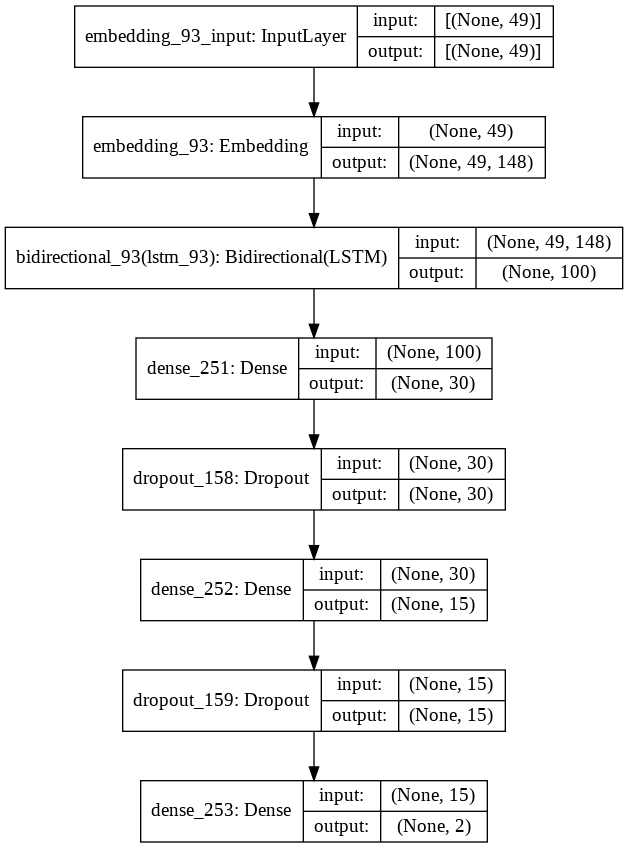

In [167]:
from keras.utils.vis_utils import plot_model
dot_img_file = 'model_1.png'
plot_model(model_, to_file= dot_img_file, show_shapes=True, show_layer_names=True)

In [168]:
# Evaluate the model1
loss, acc = model_.evaluate(X_test, Y_test, verbose=1)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

19/19 [==============================] - 3s 42ms/step - loss: 0.6911 - accuracy: 0.7517
Untrained model, accuracy: 75.17%


In [117]:
#test validation
from sklearn.metrics import confusion_matrix,classification_report


Y_pred = model_.predict_classes(X_test,batch_size = 32)
df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


confusion matrix [[190  97]
 [ 52 261]]
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       287
           1       0.73      0.83      0.78       313

    accuracy                           0.75       600
   macro avg       0.76      0.75      0.75       600
weighted avg       0.76      0.75      0.75       600



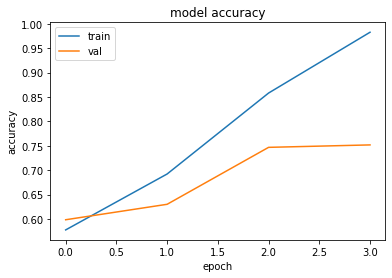

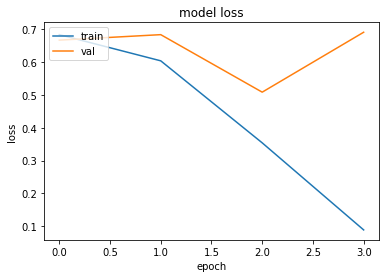

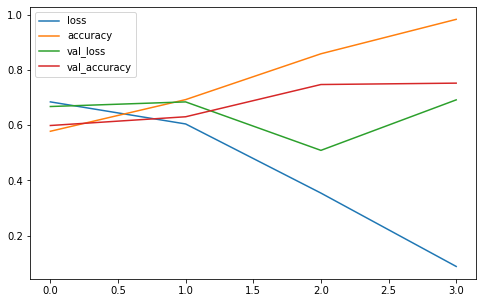

In [195]:
history=np.load('/content/my_history_BLSTM_corpus2.npy',allow_pickle='TRUE').item()
#This builds a graph with the available metrics of the history for all datasets of the history
from matplotlib import pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
pd.DataFrame(history).plot(figsize=(8,5))
plt.show()

In [198]:
##predict sentiments from BLSTM model (best model accuracy)

#text = ['bravo arbeya enti b alef rajel w zied el meki désolé sonbel a8a ragas el fehri eli ken chochou trabelseya ezouz mahomchi rjel w laba tjib laba w tjib esid da3as w etiiiiiiiit tjib etiiiiiiit w']
text = ['araftha aka tebda fel 5ra lrasek w t9olhom le le jawi behy']

def pred(text):
  #vectorizing the tweet by the pre-fitted tokenizer instance
  twt = token.texts_to_sequences(text)
  #padding the tweet to have exactly the same shape as `embedding_2` input
  twt = pad_sequences(twt, maxlen=max_length, dtype='int32', value=0)
  print(text)
  print(twt)
  sentiment = model_.predict(twt)[0]
  if ((sentiment[0])>0.5):
    print("positive")
  elif ((sentiment[0])<=0.5):
    print("negative")

pred(text)    

['araftha aka tebda fel 5ra lrasek w t9olhom le le jawi behy']
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  354 4247
  4248 4249 4250   14   14 1592  736]]
negative
